In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST, FashionMNIST
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import cv2
from copy import deepcopy
import os
from torchvision.transforms import ToTensor


In [16]:

# Function to save the dataset
def save_dataset(dataset, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(dataset, path)
    print(f"Dataset saved to {path}")

# Get the current directory path
current_directory = os.getcwd()

# Define the directory to save the dataset in the parent directory
save_dir = os.path.join(current_directory, 'Dataset', 'dataset1', 'data')

def load_dataset(path, dataset_name, is_train):
    if os.path.exists(path):
        dataset = torch.load(path)
        print(f"Dataset loaded from {path}")
    else:
        print(f"No dataset found at {path}, downloading a new one...")
        if dataset_name == "FMNIST":
            dataset = FashionMNIST(root=save_dir, train=is_train, download=True, transform=ToTensor())
        else:
            dataset = MNIST(root=save_dir, train=is_train, download=True, transform=ToTensor())
        save_dataset(dataset, path)
    return dataset

# Define paths for the MNIST and Fashion MNIST datasets
paths = {
    "MNIST": {
        "train": os.path.join(save_dir, 'MNIST_train.pt'),
        "test": os.path.join(save_dir, 'MNIST_test.pt')
    },
    "FMNIST": {
        "train": os.path.join(save_dir, 'FashionMNIST_train.pt'),
        "test": os.path.join(save_dir, 'FashionMNIST_test.pt')
    }
}



In [17]:
train_mnist = load_dataset(paths["MNIST"]["train"], "MNIST", True)
test_mnist = load_dataset(paths["MNIST"]["test"], "MNIST", False)
train_fmnist = load_dataset(paths["FMNIST"]["train"], "FMNIST", True)
test_fmnist = load_dataset(paths["FMNIST"]["test"], "FMNIST", False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Dataset loaded from c:\Users\Atefe Rajabi\PycharmProjects\Deep-Learning\HW3\Dataset\dataset1\data\MNIST_train.pt
Dataset loaded from c:\Users\Atefe Rajabi\PycharmProjects\Deep-Learning\HW3\Dataset\dataset1\data\MNIST_test.pt
Dataset loaded from c:\Users\Atefe Rajabi\PycharmProjects\Deep-Learning\HW3\Dataset\dataset1\data\FashionMNIST_train.pt
Dataset loaded from c:\Users\Atefe Rajabi\PycharmProjects\Deep-Learning\HW3\Dataset\dataset1\data\FashionMNIST_test.pt


In [18]:
class MixMNIST(Dataset):
    def __init__(self, mnist, fashion):
        self.mnist = mnist
        self.fashion = fashion
        self.transform = transforms.Compose([
            transforms.ToTensor()])

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        fm = self.fashion[idx]
        m = self.mnist[idx]

        m = self.transform(m[..., None].numpy().astype(np.uint8))
        fm = self.transform(fm[..., None].numpy().astype(np.uint8))
        image = (m + fm) / 2
        return image.flatten(), image.flatten()

In [19]:
train_ds = MixMNIST(train_mnist.data, train_fmnist.data)
val_ds = MixMNIST(test_mnist.data, test_fmnist.data)

train_data = DataLoader(train_ds, batch_size = 32)
val_data = DataLoader(val_ds)

In [20]:
class Encoder(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(Encoder, self).__init__()
        self.in2h = nn.Sequential(nn.Linear(in_dim, h_dim), nn.BatchNorm1d(h_dim), nn.ReLU(),
                                  nn.Linear(h_dim, h_dim//2), nn.BatchNorm1d(h_dim//2), nn.ReLU(),
                                  nn.Linear(h_dim//2, h_dim//4), nn.BatchNorm1d(h_dim//4), nn.ReLU(),
                                  nn.Linear(h_dim//4, h_dim//8), nn.BatchNorm1d(h_dim//8), nn.ReLU(),)
        self.h2mean1 = nn.Linear(h_dim//8, out_dim)
        self.h2var1 = nn.Linear(h_dim//8, out_dim)
        self.h2mean2 = nn.Linear(h_dim//8, out_dim)
        self.h2var2 = nn.Linear(h_dim//8, out_dim)

    def forward(self, x):
        hidden = self.in2h(x)
        mean1 = self.h2mean1(hidden)
        var1 = self.h2var1(hidden)
        mean2 = self.h2mean2(hidden)
        var2 = self.h2var2(hidden)
        return mean1, var1, mean2, var2

class Decoder(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(Decoder, self).__init__()
        self.in2out = nn.Sequential(nn.Linear(in_dim, 2*in_dim), nn.BatchNorm1d(2*in_dim), nn.ReLU(),
                                    nn.Linear(2*in_dim, 4*in_dim), nn.BatchNorm1d(4*in_dim), nn.ReLU(),
                                    nn.Linear(4*in_dim, 8*in_dim), nn.BatchNorm1d(8*in_dim), nn.ReLU(),
                                    nn.Linear(8*in_dim, h_dim), nn.BatchNorm1d(h_dim), nn.ReLU(),
                                    nn.Linear(h_dim, out_dim), nn.Sigmoid())

    def forward(self, x):
        return self.in2out(x)

class VAE(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(in_dim, h_dim, out_dim)
        self.decoder1 = Decoder(out_dim, h_dim, in_dim)
        self.decoder2 = Decoder(out_dim, h_dim, in_dim)

    def forward(self, x):
        mean1, var1, mean2, var2 = self.encoder(x)
        new_samples1 = mean1 + torch.randn_like(var1) * var1.exp().sqrt()
        new_samples2 = mean2 + torch.randn_like(var2) * var2.exp().sqrt()
        recons1 = self.decoder1(new_samples1)
        recons2 = self.decoder2(new_samples2)
        recons = (recons1 + recons2) * 0.5
        return recons, recons1, recons2, mean1, var1, mean2, var2

class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()
        self.mse = nn.BCELoss(reduction = 'sum')

    def forward(self, y_pred, y_true, mean1, var1, mean2, var2):
        mse = self.mse(y_pred, y_true)
        kullback1 = -0.5 * (1 + var1 - mean1**2 - var1.exp()).sum()
        kullback2 = -0.5 * (1 + var2 - mean2**2 - var2.exp()).sum()
        return mse + kullback1 + kullback2

In [21]:
model =  VAE(28 * 28, 512, 32)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = VAELoss()

In [23]:
def train_model(model, train_data, criterion, optimizer, epochs, val_data, device = device):
    model.to(device)
    best = model.state_dict()
    min_val = 10
    model.train()
    tr_l, v_l = [], []
    for epoch in range(epochs):
        tr_loss = 0
        tr_acc = 0
        val_loss = 0
        val_acc = 0
        model.train()
        for images, labels in tqdm(train_data):
            images = images.to(device)
            labels = labels.to(device)
            preds, c1, c2, mean1, var1, mean2, var2 = model(images)
            loss = criterion(preds, labels, mean1, var1, mean2, var2)
            tr_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        for images, labels in val_data:
            images = images.to(device)
            labels = labels.to(device)
            preds, c1, c2, mean1, var1, mean2, var2 = model(images)
            loss = criterion(preds, labels, mean1, var1, mean2, var2)
            val_loss += loss.item()
        tr_loss /= len(train_data)
        val_loss /= len(val_data)
        tr_l.append(tr_loss)
        v_l.append(val_loss)
        print(f'epoch: {epoch} loss: {tr_loss} val_loss: {val_loss}')
        if val_loss < min_val:
            min_val = val_loss
            best = deepcopy(model.state_dict())
    model.load_state_dict(best)
    return tr_l, v_l

In [24]:
a,b = train_model(model, train_data, criterion, optimizer, 40, val_data, device = device)

  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 1875/1875 [01:17<00:00, 24.04it/s]


epoch: 0 loss: 10009.540803645834 val_loss: 297.9872356048584


100%|██████████| 1875/1875 [01:45<00:00, 17.79it/s]


epoch: 1 loss: 9444.3279921875 val_loss: 291.5305316772461


100%|██████████| 1875/1875 [01:21<00:00, 23.14it/s]


epoch: 2 loss: 9293.004949479167 val_loss: 287.7982107269287


100%|██████████| 1875/1875 [01:19<00:00, 23.56it/s]


epoch: 3 loss: 9206.222086979167 val_loss: 285.93693211364746


100%|██████████| 1875/1875 [01:21<00:00, 23.04it/s]


epoch: 4 loss: 9151.861096354167 val_loss: 284.0423441749573


100%|██████████| 1875/1875 [01:30<00:00, 20.62it/s]


epoch: 5 loss: 9102.248127604167 val_loss: 282.6613635101318


100%|██████████| 1875/1875 [01:18<00:00, 24.03it/s]


epoch: 6 loss: 9050.292306770833 val_loss: 281.1536965820313


100%|██████████| 1875/1875 [01:17<00:00, 24.11it/s]


epoch: 7 loss: 9012.593145572917 val_loss: 280.2232369850159


100%|██████████| 1875/1875 [01:19<00:00, 23.58it/s]


epoch: 8 loss: 8983.6529046875 val_loss: 279.628280418396


100%|██████████| 1875/1875 [01:17<00:00, 24.04it/s]


epoch: 9 loss: 8962.997173958332 val_loss: 278.9325762123108


100%|██████████| 1875/1875 [01:23<00:00, 22.42it/s]


epoch: 10 loss: 8948.8922421875 val_loss: 278.69196791000365


100%|██████████| 1875/1875 [01:23<00:00, 22.45it/s]


epoch: 11 loss: 8935.228548697916 val_loss: 278.22204228744505


100%|██████████| 1875/1875 [01:16<00:00, 24.56it/s]


epoch: 12 loss: 8924.243539322917 val_loss: 278.1101733795166


100%|██████████| 1875/1875 [01:20<00:00, 23.42it/s]


epoch: 13 loss: 8914.638228125 val_loss: 278.0543715736389


100%|██████████| 1875/1875 [01:13<00:00, 25.35it/s]


epoch: 14 loss: 8906.229751822917 val_loss: 277.684781653595


100%|██████████| 1875/1875 [01:26<00:00, 21.77it/s]


epoch: 15 loss: 8897.65370078125 val_loss: 277.5728371360779


100%|██████████| 1875/1875 [01:30<00:00, 20.69it/s]


epoch: 16 loss: 8889.7410890625 val_loss: 277.467940953064


100%|██████████| 1875/1875 [01:22<00:00, 22.64it/s]


epoch: 17 loss: 8882.3906796875 val_loss: 277.31299435501097


100%|██████████| 1875/1875 [01:19<00:00, 23.52it/s]


epoch: 18 loss: 8875.651367708333 val_loss: 277.1975304450989


100%|██████████| 1875/1875 [01:22<00:00, 22.68it/s]


epoch: 19 loss: 8869.103314322916 val_loss: 277.0365201774597


100%|██████████| 1875/1875 [01:36<00:00, 19.34it/s]


epoch: 20 loss: 8863.114085677083 val_loss: 276.84747459487915


100%|██████████| 1875/1875 [01:48<00:00, 17.35it/s]


epoch: 21 loss: 8856.734071354167 val_loss: 276.6140183830261


100%|██████████| 1875/1875 [01:34<00:00, 19.92it/s]


epoch: 22 loss: 8851.487788020833 val_loss: 276.5675431419373


100%|██████████| 1875/1875 [01:31<00:00, 20.48it/s]


epoch: 23 loss: 8846.419292708333 val_loss: 276.4579646080017


100%|██████████| 1875/1875 [01:31<00:00, 20.43it/s]


epoch: 24 loss: 8842.11619765625 val_loss: 276.27251426620484


100%|██████████| 1875/1875 [01:21<00:00, 23.13it/s]


epoch: 25 loss: 8837.939579947917 val_loss: 276.3693835678101


100%|██████████| 1875/1875 [01:15<00:00, 24.83it/s]


epoch: 26 loss: 8834.538408072916 val_loss: 276.2945124862671


100%|██████████| 1875/1875 [01:16<00:00, 24.39it/s]


epoch: 27 loss: 8829.287374739582 val_loss: 276.12742132720945


100%|██████████| 1875/1875 [01:16<00:00, 24.41it/s]


epoch: 28 loss: 8826.02020859375 val_loss: 276.0569699432373


100%|██████████| 1875/1875 [01:16<00:00, 24.66it/s]


epoch: 29 loss: 8822.411372916667 val_loss: 276.04450588150024


100%|██████████| 1875/1875 [01:15<00:00, 24.81it/s]


epoch: 30 loss: 8819.31888515625 val_loss: 275.8585606895447


100%|██████████| 1875/1875 [01:25<00:00, 21.97it/s]


epoch: 31 loss: 8814.724983072916 val_loss: 275.9232724998474


100%|██████████| 1875/1875 [01:26<00:00, 21.69it/s]


epoch: 32 loss: 8812.558881510417 val_loss: 275.9939690635681


100%|██████████| 1875/1875 [01:22<00:00, 22.64it/s]


epoch: 33 loss: 8810.065325520833 val_loss: 275.8916130332947


100%|██████████| 1875/1875 [01:22<00:00, 22.77it/s]


epoch: 34 loss: 8806.429751822916 val_loss: 275.91827988815305


100%|██████████| 1875/1875 [01:15<00:00, 24.71it/s]


epoch: 35 loss: 8804.955516927082 val_loss: 275.6409461959839


100%|██████████| 1875/1875 [01:20<00:00, 23.32it/s]


epoch: 36 loss: 8801.155994270834 val_loss: 275.85361423797605


100%|██████████| 1875/1875 [01:13<00:00, 25.55it/s]


epoch: 37 loss: 8799.9417921875 val_loss: 275.8615609916687


100%|██████████| 1875/1875 [01:20<00:00, 23.20it/s]


epoch: 38 loss: 8796.046290625 val_loss: 275.6364498031616


100%|██████████| 1875/1875 [01:12<00:00, 25.76it/s]


epoch: 39 loss: 8793.607826822918 val_loss: 275.6589370437622


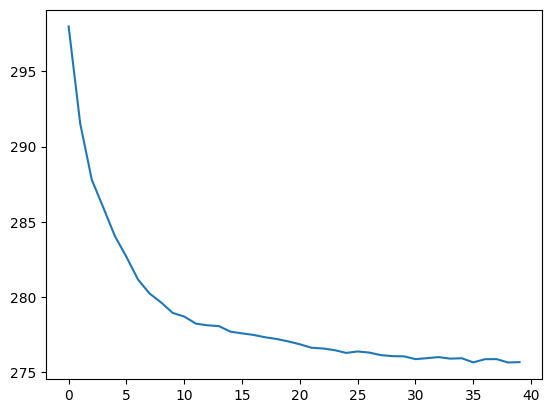

In [25]:
# validation loss
plt.plot(b)

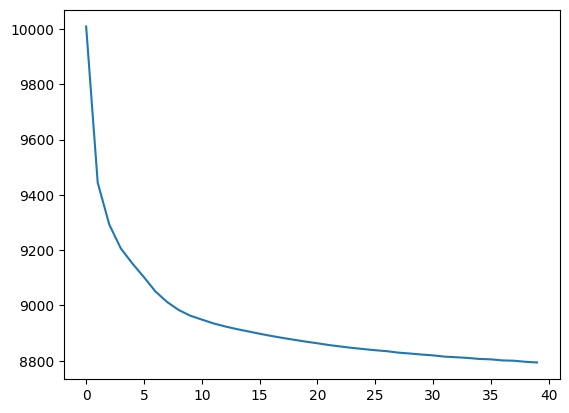

In [26]:
# train loss
plt.plot(a)

  0%|          | 9/10000 [00:01<19:07,  8.70it/s]


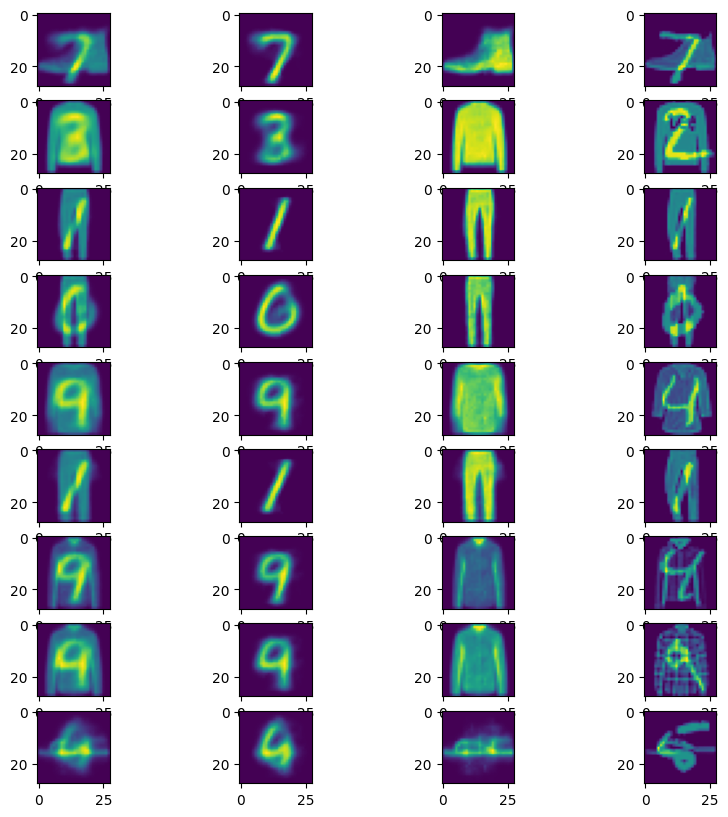

In [27]:
i = 0
plt.figure(figsize = (10, 10))
for images, labels in tqdm(val_data):
    if i > 8:
        break
    images = images.to(device)
    labels = labels.to(device)
    preds, c1, c2, mean, var, _, _ = model(images)
    #loss = criterion(preds, labels, mean, var)
    preds = preds.detach().cpu().numpy().reshape((28, 28))
    c1 = c1.detach().cpu().numpy().reshape((28, 28))
    c2 = c2.detach().cpu().numpy().reshape((28, 28))
    c1 = (c1 - c1.min()) / (c1.max() - c1.min())
    c2 = (c2 - c2.min()) / (c2.max() - c2.min())
    preds = (preds - preds.min()) / (preds.max() - preds.min())
    plt.subplot(9, 4, 4 * i + 1)
    plt.imshow(preds)
    plt.subplot(9, 4, 4 * i + 2)
    plt.imshow(c1)
    plt.subplot(9, 4, 4 * i + 3)
    plt.imshow(c2)
    plt.subplot(9, 4, 4 * i + 4)
    plt.imshow(images[0].cpu().numpy().reshape((28,28)))
    i += 1